In [ ]:
!pip install torch torchvision matplotlib pillow

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
from google.colab import files
uploaded = files.upload()

Saving style.jpeg to style (3).jpeg


In [6]:
from PIL import Image

In [8]:
content_img = Image.open("profile.jpeg")
style_img = Image.open("style.jpeg")

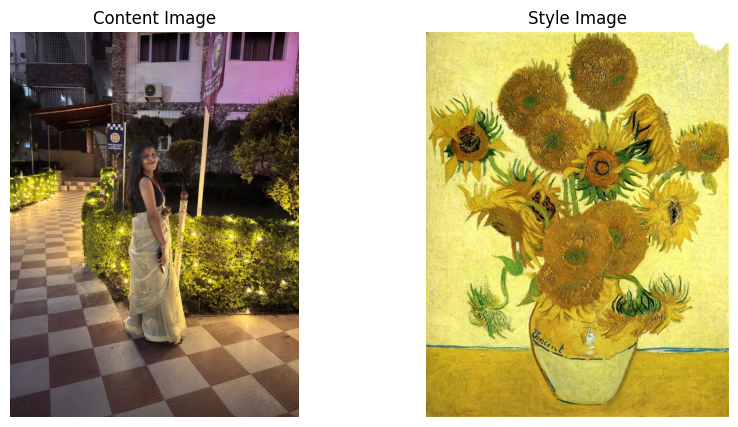

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(content_img)
plt.title("Content Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(style_img)
plt.title("Style Image")
plt.axis("off")

plt.show()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:06<00:00, 95.7MB/s]


🔄 Style transfer starting...
Step 50/200
Step 100/200
Step 150/200
Step 200/200
✅ Style transfer complete!


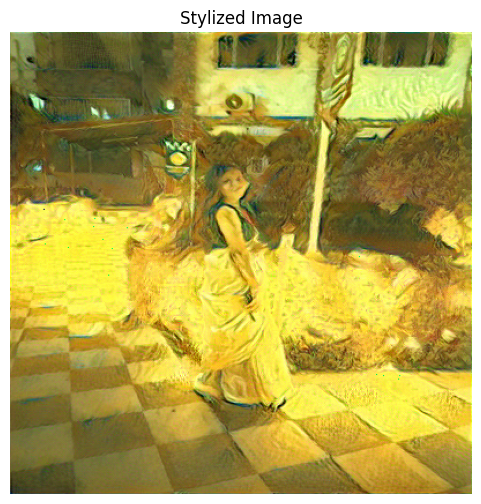

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image loader
loader = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor()
])

def image_loader(image):
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

content_tensor = image_loader(content_img)
style_tensor = image_loader(style_img)

# Load VGG19
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Loss functions
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()
    def gram_matrix(self, input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)
    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

# Normalization
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)
    def forward(self, img):
        return (img - self.mean) / self.std

# Build model
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=['conv_4'],
                               style_layers=['conv_1','conv_2','conv_3','conv_4','conv_5']):
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_" + name, content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_" + name, style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses

input_img = content_tensor.clone()

model, style_losses, content_losses = get_style_model_and_losses(
    cnn, cnn_normalization_mean, cnn_normalization_std,
    style_tensor, content_tensor
)

# Optimizer
optimizer = optim.LBFGS([input_img.requires_grad_()])

# Run style transfer
num_steps = 200
style_weight = 1000000
content_weight = 1

print("🔄 Style transfer starting...")

run = [0]
while run[0] <= num_steps:
    def closure():
        input_img.data.clamp_(0, 1)
        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        loss = style_weight * style_score + content_weight * content_score
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print(f"Step {run[0]}/{num_steps}")
        return loss

    optimizer.step(closure)

print("✅ Style transfer complete!")

# Show output
output = input_img.cpu().clone().squeeze(0)
output = transforms.ToPILImage()(output)

plt.figure(figsize=(6,6))
plt.imshow(output)
plt.axis("off")
plt.title("Stylized Image")
plt.show()

In [11]:
output.save("stylized_output.jpg")
print("📁 Image saved as stylized_output.jpg")

📁 Image saved as stylized_output.jpg
